In [386]:
#custom neural networkx models
import neural_networks as ann
#other imports
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import seaborn as sns

# Load model and autoencoder

That were trained on different script

In [2]:
#main model
conv_net = ann.ConvNet()
extra_layer = ann.Extra_layer()
model = nn.Sequential(conv_net, extra_layer)
model.load_state_dict(torch.load('model_checkpoint.pth'))
model.eval()

#autoencoder
autoencoder = ann.Autoencoder()
autoencoder.load_state_dict(torch.load('autoencoder_checkpoint.pth'))
model.eval()

Sequential(
  (0): ConvNet(
    (conv_layers): Sequential(
      (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
      (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
      (4): Dropout(p=0.5, inplace=False)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): ReLU()
    )
    (fc_layers): Sequential(
      (0): Linear(in_features=320, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (1): Extra_layer(
    (bin): Linear(in_features=10, out_features=2, bias=True)
  )
)

# Load data

In [4]:
# Specify the target digit for binary classification
batch_size_train = 128
batch_size_test = 1000
target_digit = 9
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
# Create binary classification train and test loaders
binary_train_loader = DataLoader(ann.BinaryMNIST('mnist_data/', train=True, transform=transform, target_digit=target_digit),
                          batch_size=batch_size_train, shuffle=True)
binary_test_loader = DataLoader(ann.BinaryMNIST('mnist_data/', train=False, transform=transform, target_digit=target_digit),
                         batch_size=batch_size_test, shuffle=True)

# CROCO

Starting with croco exploration on the MNIST dataset

In [62]:
#import custom implementation of Croco
import gator
from importlib import reload
gator = reload(gator)

In [63]:
data_iter = enumerate(binary_test_loader)
batch_idx, (data, targets) = next(data_iter)
ones = (targets==1).nonzero()
x = data[ones[0]]


In [84]:
factual = data[ones[17]].clone().detach()

counterfactual, hist = gator.croco(
                        model=model,
                        autoencoder=None,
                        input_data=factual,
                        weights = {"robustness":0.5,"validity":1,"proximity":0.01}, #robustness, validity, proximity
                        sigma2=0.2,
                        max_iter = 1000,
                        learning_rate=0.01,
                        n_samples=500,
                        device = "cpu"
                        )

latent_counterfactual, hist = gator.croco(
                        model=model,
                        autoencoder=autoencoder,
                        input_data=factual,
                        weights = {"robustness":0.5,"validity":1,"proximity":0.01}, #robustness, validity, proximity
                        sigma2=0.2,
                        max_iter = 1000,
                        learning_rate=0.01,
                        n_samples=500,
                        device = "cpu"
                        )

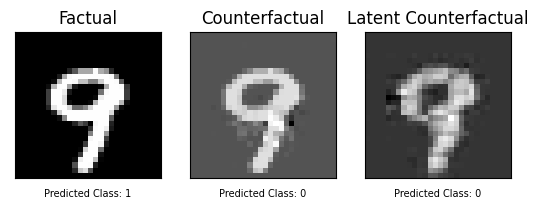

In [88]:
mosaic = """
ABC
"""
fig, axs = plt.subplot_mosaic(mosaic)
for img,ax,title in zip([factual,counterfactual,latent_counterfactual],["A","B","C"],["Factual","Counterfactual","Latent Counterfactual"]):
    axs[ax].imshow(img.detach().view(28, 28), cmap='gray', interpolation='none')
    predicted_class = torch.argmax(model(img.detach()), dim=1).item()
    axs[ax].set_xlabel(f"Predicted Class: {predicted_class}",fontsize=7)
    axs[ax].set_title(title)
    axs[ax].set_xticks([])
    axs[ax].set_yticks([])
plt.show()

# Robustness Comparison

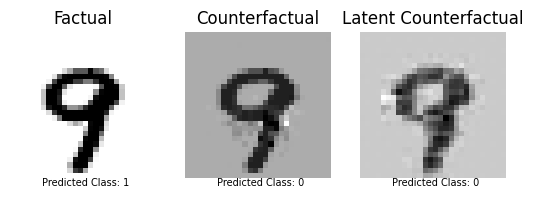

In [651]:
mosaic = """
ABC
"""
fig, axs = plt.subplot_mosaic(mosaic)
for img,ax,title in zip([factual,counterfactual,latent_counterfactual],["A","B","C"],["Factual","Counterfactual","Latent Counterfactual"]):
    axs[ax].imshow(img.detach().view(28, 28), cmap='gray_r', interpolation='none')
    predicted_class = torch.argmax(model(img.detach()), dim=1).item()
    axs[ax].text(14,29,f"Predicted Class: {predicted_class}",fontsize=7,ha="center")
    axs[ax].set_title(title)
    axs[ax].set_xticks([])
    axs[ax].set_yticks([])
    axs[ax].axis("off")
plt.show()

# Latent robustness

In [94]:
# GIVEN A COUNTERFACTUAL EVALUATE ITS ROBUSTNESS

latent_robustness,std_robustness = [],[]
for radius in np.linspace(0.01,0.3,100):
    #robustness of standard counterfactual
    std_recourse = gator.recourse_invalidation(
        model, #classification model
        factual, # factual data. assumed traget is 1
        counterfactual.detach(), # counter factual to evaluate robustness
        sigma2=radius, # neighbourbhood radius
        device="cpu",
        n_samples=500
    )
    std_robustness.append(std_recourse.item())
    
    
    #robustness of latent counterfactual
    latent_recourse = gator.recourse_invalidation(
        model, #classification model
        factual, # factual data. assumed traget is 1
        latent_counterfactual.detach(), # counter factual to evaluate robustness
        sigma2=radius, # neighbourbhood radius
        device="cpu",
        n_samples=500
    )
    latent_robustness.append(latent_recourse.item())

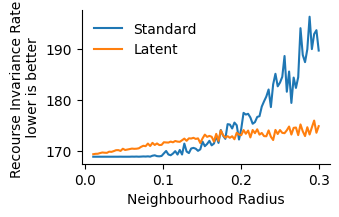

In [392]:
fig,ax = plt.subplots(figsize=(3.2,2.0))
plt.plot(np.linspace(0.01,0.3,100),std_robustness,label="Standard")
plt.plot(np.linspace(0.01,0.3,100),latent_robustness,label="Latent")
plt.ylabel("Recourse Invariance Rate \n lower is better ")
plt.xlabel("Neighbourhood Radius")
plt.legend(frameon=False)
sns.despine()
plt.savefig("figures/latent_robustness.pdf",bbox_inches="tight")
plt.show()

In [417]:
latent_distances, std_distances = [],[]

for _, (datapoints, targets) in enumerate(binary_test_loader):
    batch_tensor = datapoints[targets==1]
    std_distances.extend(torch.norm(counterfactual.detach() - batch_tensor, dim=[1, 2, 3],p=2).detach().numpy())
    latent_distances.extend(torch.norm(latent_counterfactual.detach() - batch_tensor, dim=[1, 2, 3],p=2).detach().numpy())

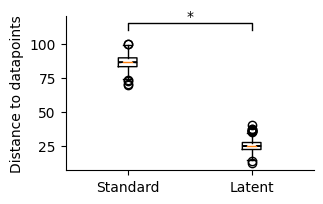

In [435]:
h = 5
y = 110

fig,ax = plt.subplots(figsize=(3.2,2.0))
ax.boxplot([std_distances,latent_distances],["Standard","Latent"])
ax.plot([1, 1, 2, 2], [y, y + h, y + h, y], linewidth=1, color="k")
ax.text((3) * 0.5, y + h, "*", ha="center", va="bottom", color="k")
ax.set_ylabel("Distance to datapoints")
ax.set_xticks([1,2],["Standard","Latent"])
sns.despine()
plt.savefig("figures/latent_distances.pdf",bbox_inches="tight")
plt.show()

# Abele

In [682]:
#save the factual for comparing in another notebook
#np.save('factual.npy', factual.clone().detach().numpy())    # .npy extension is added if not given

#load the abele counterfactual
abele = np.load('abele_counterfactuals_3.npy')

In [753]:
def prep_abele(count):
    tens = torch.tensor(count.reshape(1,1,28,28)).to("cpu").float().detach()
    return tens #transforms.Normalize((0.1307,), (0.3081,))(tens)

abele_counters = [prep_abele(abe[:,:,0]) for abe in abele]

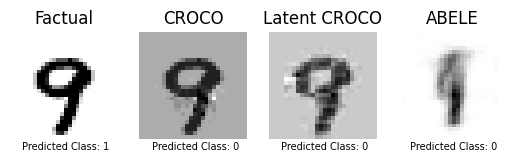

In [847]:
mosaic = """
ABCD
"""
fig, axs = plt.subplot_mosaic(mosaic)
for img,ax,title in zip([factual,counterfactual,latent_counterfactual,abele_counters[1]],["A","B","C","D"],["Factual","CROCO","Latent CROCO","ABELE"]):
    axs[ax].imshow(img.detach().view(28, 28), cmap='gray_r', interpolation='none')
    predicted_class = torch.argmax(model(img.detach()), dim=1).item()
    axs[ax].text(14,30,f"Predicted Class: {predicted_class}",fontsize=7,ha="center")
    axs[ax].set_title(title)
    axs[ax].set_xticks([])
    axs[ax].set_yticks([])
    axs[ax].axis("off")
plt.savefig("figures/all_counterfactuals.pdf",bbox_inches="tight")
plt.show()

In [744]:
abele_robustness = []
for radius in np.linspace(0.01,0.3,100):
    #robustness of standard counterfactual
    ab_recourse = gator.recourse_invalidation(
        model, #classification model
        factual, # factual data. assumed traget is 1
        abele_counters[1], # counter factual to evaluate robustness
        sigma2=radius, # neighbourbhood radius
        device="cpu",
        n_samples=500
    )
    abele_robustness.append(ab_recourse.item())

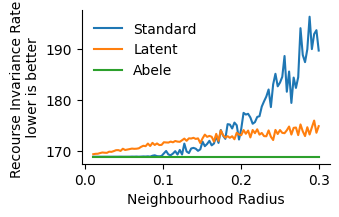

In [843]:
fig,ax = plt.subplots(figsize=(3.2,2.0))

plt.plot(np.linspace(0.01,0.3,100),std_robustness,label="Standard")
plt.plot(np.linspace(0.01,0.3,100),latent_robustness,label="Latent")
plt.plot(np.linspace(0.01,0.3,100),abele_robustness,label="Abele")
plt.ylabel("Recourse Invariance Rate \n lower is better ")
plt.xlabel("Neighbourhood Radius")
plt.legend(frameon=False)
sns.despine()
#plt.savefig("figures/latent_robustness.pdf",bbox_inches="tight")
plt.savefig("figures/counterfactual_robustness.pdf",bbox_inches="tight")
plt.show()

In [748]:
abele_distances = []
for _, (datapoints, targets) in enumerate(binary_test_loader):
    batch_tensor = datapoints[targets==1]
    abele_distances.extend(torch.norm(abele_counters[1] - batch_tensor, dim=[1, 2, 3],p=2).detach().numpy())

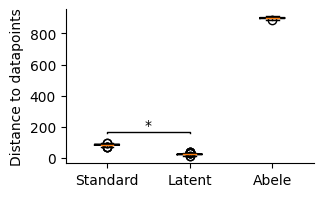

In [846]:
h = 5
y = 160

fig,ax = plt.subplots(figsize=(3.2,2.0))
ax.boxplot([std_distances,latent_distances,abele_distances],["Standard","Latent","Abele"])
ax.plot([1, 1, 2, 2], [y, y + h, y + h, y], linewidth=1, color="k")
ax.text((3) * 0.5, y + h, "*", ha="center", va="bottom", color="k")
ax.set_ylabel("Distance to datapoints")
ax.set_xticks([1,2,3],["Standard","Latent","Abele"])
sns.despine()
plt.savefig("figures/counterfactual_distance.pdf",bbox_inches="tight")
plt.show()


# Viz Comparison

In [758]:
data,targets = [],[]
for batch_idx, (data_, targets_) in enumerate(binary_test_loader):
    if batch_idx>3:
        break
    data.extend([row.flatten() for row in data_.detach().numpy()])
    targets.extend(targets_.detach().numpy())

In [799]:
import umap.umap_ as umap
from sklearn.decomposition import PCA

#mapper = umap.UMAP(n_neighbors=5).fit(data,y = targets)
mapper = PCA(n_components=2).fit(data)
embedding = mapper.transform(data)


In [800]:
def select_points_minmax(points, n):
    selected_indexes = []
    remaining_indexes = set(range(len(points)))

    # Find the point with the maximum distance to the current selection
    def find_farthest_point(selected_indexes):
        distances = np.min(np.linalg.norm(points[selected_indexes][:, np.newaxis] - points, axis=-1), axis=0)
        return np.argmax(distances)

    # Start with a random point
    current_index = np.random.choice(list(remaining_indexes))
    selected_indexes.append(current_index)
    remaining_indexes.remove(current_index)

    # Add points until reaching the desired number
    while len(selected_indexes) < n:
        farthest_index = find_farthest_point(selected_indexes)
        selected_indexes.append(farthest_index)
        remaining_indexes.remove(farthest_index)

    return selected_indexes
indexes = select_points_minmax(embedding, 10)

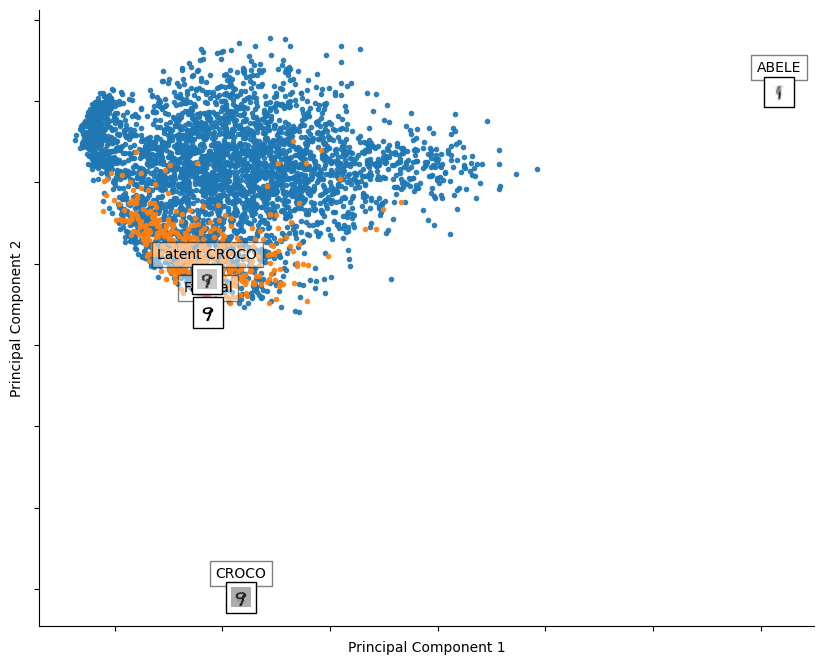

In [841]:
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

fig, ax = plt.subplots(figsize=(10,8))
mask = np.array(targets)==1
ax.scatter(embedding[~mask,0],embedding[~mask,1],marker=".",alpha=0.9)
ax.scatter(embedding[mask,0],embedding[mask,1],marker=".",alpha=0.9)

for count,label in zip([factual,counterfactual,latent_counterfactual,abele_counters[1]],
                 ["Factual","CROCO","Latent CROCO","ABELE"]):
    plt.scatter(coords[:,0],coords[:,1],s=20,color="red",label=label)
    image = count.detach().numpy().flatten()
    coords = mapper.transform(image.reshape(1,-1))
    x, y = coords[0,0],coords[0,1]
    im = OffsetImage(image.reshape((28,28)), zoom=0.5,cmap='gray_r')
    im.image.axes = ax
    if label=="Latent CROCO":
        x,y = x,y+2
    ab = AnnotationBbox(im, (x,y),
                        xycoords='data',
                        frameon=True)
    ab.txt_label = plt.text(x, y+3, label, ha='center', va='center',bbox=dict(facecolor='white', alpha=0.5))
    ax.add_artist(ab)

#plt.legend()
plt.ylabel("Principal Component 2")
plt.xlabel("Principal Component 1")
ax.set_xticklabels([])  # Remove x-axis tick labels
ax.set_yticklabels([])  # Remove y-axis tick labels
sns.despine()
plt.savefig("figures/counterfactual_position.pdf")
plt.show()

In [818]:
points = [factual,counterfactual,latent_counterfactual,abele_counters[1]]

A = np.zeros((4,4))
for i,p1 in enumerate(points):
    for j,p2 in enumerate(points):
        A[i,j] = torch.norm(p1 - p2,p=2).detach().numpy()

In [830]:
from sklearn.manifold import MDS
dots = MDS(dissimilarity='precomputed').fit_transform(A)

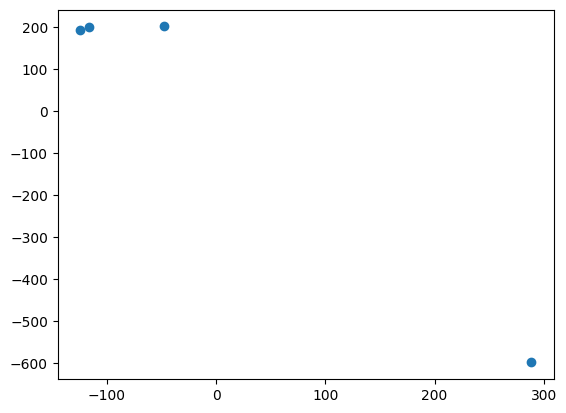

In [833]:
plt.scatter(dots[:,0],dots[:,1])
plt.show()

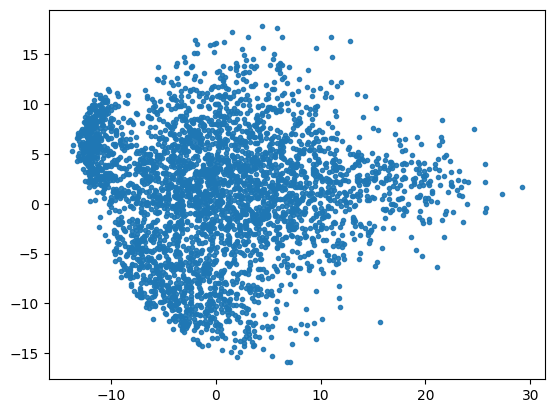

In [845]:
plt.scatter(embedding[~mask,0],embedding[~mask,1],marker=".",alpha=0.9)
plt.show()